# MNIST handwritten digits

MLP - MNIST 손글씨 숫자 인식

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 1. Load Dataset

MNIST dataset loading

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()    # load mnist data
x_train, x_test = x_train / 255.0, x_test / 255.0

## 2. Dataset split

train dataset에 60000개 데이터가 있으므로, 랜덤하게 split하여 3만개의 학습데이터만 사용

In [3]:
import random

rand_selected = random.sample([x for x in range(0, len(x_train))], 30000)
x_train = x_train[rand_selected]
y_train = y_train[rand_selected]

print(f"shape of x_train is {tf.shape(x_train)}")
print(f"shape of y_train is {tf.shape(y_train)}")
print(f"shape of x_test is {tf.shape(x_test)}")
print(f"shape of y_test is {tf.shape(y_test)}")

shape of x_train is [30000    28    28]
shape of y_train is [30000]
shape of x_test is [10000    28    28]
shape of y_test is [10000]


## 3. Training data preprocessing

### 3.1. Data Normalize

In [4]:
mean = np.mean(x_train)
std = np.std(x_train)

x_train = (x_train - mean)/std
x_test = (x_test - mean)/std

### 3.2. Data enhance - By shifting and rotating

In [5]:
from scipy.ndimage.interpolation import shift

x_enhanced = []
y_enhanced = []

shifting_list = [
    [0, 1],
    [1, 0], 
    [-1, 0],
    [0, -1],
    [1, 1],
    [-1, 1],
    [1, -1],
    [-1, -1]
]

for x_shift, y_shift in shifting_list:
     for image, label in zip(x_train, y_train):
        shifted_image = shift(image, [y_shift, x_shift])
        shifted_image.reshape([-1])
        x_enhanced.append(shifted_image)
        y_enhanced.append(label)

shifted_x_train = np.array(x_enhanced)
shifted_y_train = np.array(y_enhanced)

print(f"shape of shifted_x_train is {np.shape(shifted_x_train)}")
print(f"shape of shifted_y_train is {np.shape(shifted_y_train)}")

shape of shifted_x_train is (240000, 28, 28)
shape of shifted_y_train is (240000,)


In [6]:
import imutils

x_enhanced = []
y_enhanced = []

rotating_list = [10, 20, 30]

for rotate_angle in rotating_list:
    for image, label in zip(x_train, y_train):
        positive_rotated_image = imutils.rotate(image, rotate_angle)
        negative_rotated_image = imutils.rotate(image, -rotate_angle)
        x_enhanced.append(positive_rotated_image)
        y_enhanced.append(label)
        x_enhanced.append(negative_rotated_image)
        y_enhanced.append(label)

rotated_x_train = np.array(x_enhanced)
rotated_y_train = np.array(y_enhanced)

print(f"shape of rotated_x_train is {np.shape(rotated_x_train)}")
print(f"shape of rotated_y_train is {np.shape(rotated_y_train)}")

shape of rotated_x_train is (180000, 28, 28)
shape of rotated_y_train is (180000,)


In [7]:
x_train = np.append(x_train, shifted_x_train, 0)
x_train = np.append(x_train, rotated_x_train, 0)
shifted_x_train = []
rotated_x_train = []

y_train = np.append(y_train, shifted_y_train, 0)
y_train = np.append(y_train, rotated_y_train, 0)
shifted_y_train = []
rotated_y_train = []

rand_selected = random.sample([x for x in range(0, len(x_train))], len(x_train))
x_train = np.array(x_train)[rand_selected]
y_train = np.array(y_train)[rand_selected]

print(f"shape of x_train is {np.shape(x_train)}")
print(f"shape of y_train is {np.shape(y_train)}")

shape of x_train is (450000, 28, 28)
shape of y_train is (450000,)


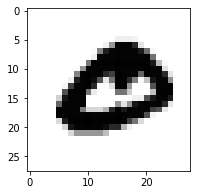

0

In [8]:
sel = random.randint(0, len(x_train))

plt.figure(figsize=(3, 3))
train_img = np.reshape(x_train[sel], [28, 28])
plt.imshow(train_img, cmap='Greys')
plt.show()

y_train[sel]

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(786, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

opt = tf.keras.optimizers.Adam(lr=0.0008)
los = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=opt,
              loss=los,
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


C:\Users\s\anaconda3\envs\tf3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [10]:
tf.device('/device:GPU:0')
model.fit(x_train, y_train, epochs=200, batch_size=128, validation_data=(x_test, y_test))

model.evaluate(x_test,  y_test)

Epoch 1/200
3516/3516 [==============================] - 155s 43ms/step - loss: 0.1639 - sparse_categorical_accuracy: 0.9517 - val_loss: 0.1114 - val_sparse_categorical_accuracy: 0.9716
Epoch 2/200
3516/3516 [==============================] - 150s 43ms/step - loss: 0.0816 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.0816 - val_sparse_categorical_accuracy: 0.9769
Epoch 3/200
3516/3516 [==============================] - 155s 44ms/step - loss: 0.0453 - sparse_categorical_accuracy: 0.9866 - val_loss: 0.0595 - val_sparse_categorical_accuracy: 0.9861
Epoch 4/200
3516/3516 [==============================] - 158s 45ms/step - loss: 0.0409 - sparse_categorical_accuracy: 0.9882 - val_loss: 0.0454 - val_sparse_categorical_accuracy: 0.9870
Epoch 5/200
3516/3516 [==============================] - 156s 44ms/step - loss: 0.0274 - sparse_categorical_accuracy: 0.9918 - val_loss: 0.0786 - val_sparse_categorical_accuracy: 0.9807
Epoch 6/200
3516/3516 [==============================] - 157s 45ms/ste

[16.373878479003906, 0.9900000095367432]